# Import The dependencies

In [1]:
import os

import numpy as np
import pandas as pd
import random

from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

from sklearn.metrics import mean_squared_error

# Load the data

In [2]:
path_lstm_data = "../collected_data/data_for_lstm/"

dict_data = dict()
list_data = list()

for dir_path in os.listdir(path_lstm_data):
    y_data_samples = []
    x_data_samples = []
    for file_name in os.listdir(path_lstm_data + f"{dir_path}"):
        dict_data[int(dir_path)] = []
        data_rec = pd.read_csv(path_lstm_data + f"{dir_path}/{file_name}")

        x_data = data_rec[['vertices', 'redexes', 'redex_depths', 'heights', 'widths']].to_numpy()
        y_data = data_rec["steps_time"].to_numpy()
        x_data_samples.append(x_data)
        y_data_samples.append(y_data)
        list_data.append((x_data, y_data))
    dict_data[int(dir_path)] = (np.array(x_data_samples), np.array(y_data_samples))

# Define the LSTM model

In [3]:
def create_lstm_model(input_shape=(None, 5)):
    model_ = Sequential()
    model_.add(LSTM(64, input_shape=input_shape, activation='relu', return_sequences=True))
    model_.add(Dense(1))

    model_.compile(loss='mean_squared_error', optimizer='rmsprop')
    return model_


def train_model(model_, x_train_data, y_train_data, epochs=1, batch_size=1):
    return model_.fit(x_train_data, y_train_data, epochs=epochs, batch_size=batch_size)

In [4]:
model = create_lstm_model()

In [5]:
count_epochs = 10
histories = []

for epoch in range(count_epochs):
    print(f"{epoch}:\n")

    rand_keys = list(dict_data.keys())
    random.shuffle(rand_keys)
    for key_ in rand_keys:
        xtd, ytd = dict_data[key_]
        histories.append((key_, train_model(model, xtd, ytd)))

0:

1/1 [==============================] - 0s 9ms/step - loss: 0.0047
1:

12/12 [==============================] - 0s 2ms/step - loss: 0.0049
2:

21/21 [==============================] - 0s 1ms/step - loss: 0.0027
3:

21/21 [==============================] - 0s 1ms/step - loss: 0.0027
4:

21/21 [==============================] - 0s 1ms/step - loss: 0.0024
5:

41/41 [==============================] - 0s 2ms/step - loss: 0.0021
6:

10/10 [==============================] - 0s 3ms/step - loss: 0.0027
7:

1/1 [==============================] - 0s 9ms/step - loss: 9.4931e-04
8:

20/20 [==============================] - 0s 1ms/step - loss: 0.0017
9:

1/1 [==============================] - 0s 7ms/step - loss: 0.0067


In [6]:
losses = []
steps = []
dict_step_loss = dict()

for history in histories:
    losses.append(history[1].history["loss"][0])
    steps.append(history[0])
    if history[0] in dict_step_loss:
        dict_step_loss[history[0]].append(history[1].history["loss"][0])
    else:
        dict_step_loss[history[0]] = [history[1].history["loss"][0], ]

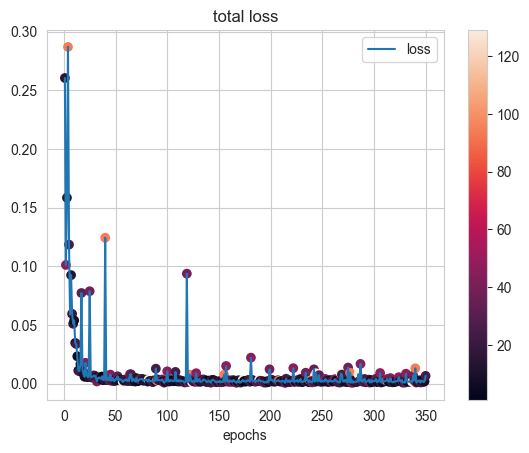

In [7]:
epoch_array = range(1, len(losses) + 1)

plt.plot(epoch_array, losses, label="loss")
plt.scatter(epoch_array, losses, c=steps)
plt.colorbar()
plt.xlabel("epochs")
plt.title("total loss")

plt.legend()
plt.show()

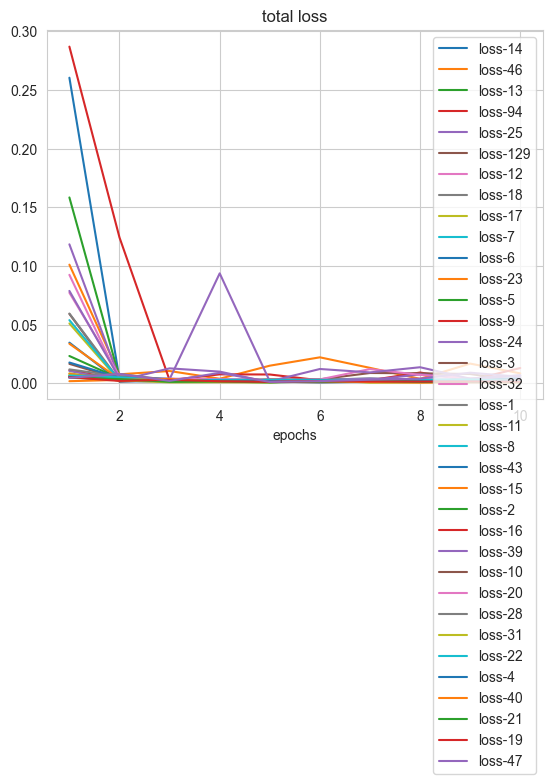

In [8]:
for key_, val_ in dict_step_loss.items():
    plt.plot(range(1, len(val_) + 1), val_, label=f"loss-{key_}")

plt.xlabel("epochs")
plt.title("total loss")

plt.legend()
plt.show()

In [4]:
def train_generator():
    while True:
        random.shuffle(list_data)
        for xtd, ytd in list_data:
            yield np.array([xtd]), np.array([ytd])

In [5]:
model = create_lstm_model()
history = model.fit(train_generator(), steps_per_epoch=450, epochs=30, verbose=1)

Epoch 1/30
450/450 [==============================] - 3s 3ms/step - loss: 0.0402
Epoch 2/30
450/450 [==============================] - 1s 2ms/step - loss: 0.0034
Epoch 3/30
450/450 [==============================] - 1s 3ms/step - loss: 0.0026
Epoch 4/30
450/450 [==============================] - 1s 3ms/step - loss: 0.0023
Epoch 5/30
450/450 [==============================] - 1s 3ms/step - loss: 0.0022
Epoch 6/30
450/450 [==============================] - 1s 3ms/step - loss: 0.0022
Epoch 7/30
450/450 [==============================] - 1s 2ms/step - loss: 0.0021
Epoch 8/30
450/450 [==============================] - 1s 3ms/step - loss: 0.0021
Epoch 9/30
450/450 [==============================] - 1s 2ms/step - loss: 0.0021
Epoch 10/30
450/450 [==============================] - 1s 3ms/step - loss: 0.0019
Epoch 11/30
450/450 [==============================] - 1s 2ms/step - loss: 0.0020
Epoch 12/30
450/450 [==============================] - 1s 3ms/step - loss: 0.0020
Epoch 13/30
450/450 [====

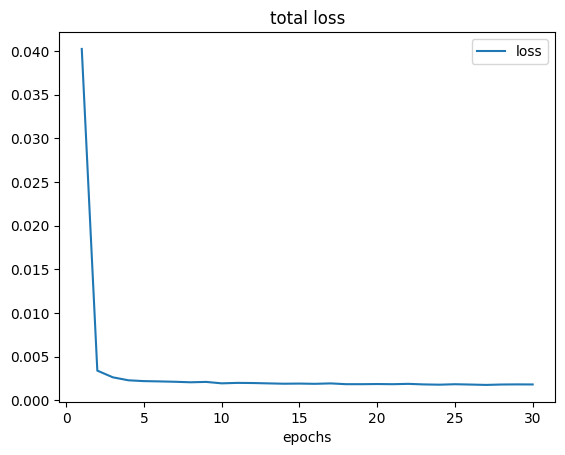

In [7]:
plt.plot(range(1, 30 + 1), history.history['loss'], label="loss")
plt.xlabel("epochs")
plt.title("total loss")

plt.legend()
plt.show()

# Test the model

In [30]:
mse_dict_full = dict()

for item_ in list_data:
    key_ = len(item_[1])

    if key_ not in mse_dict_full:
        mse_dict_full[key_] = []

    mse_dict_full[key_].append(mean_squared_error(item_[1], model.predict(np.array([item_[0]]))[0], squared=False))

mse_dict = dict()
mse_keys = list(mse_dict_full.keys())
mse_keys.sort()

for key_ in mse_keys:
    mse_dict[key_] = sum(mse_dict_full[key_]) / len(mse_dict_full[key_])

1/1 [==============================] - 0s 20ms/step


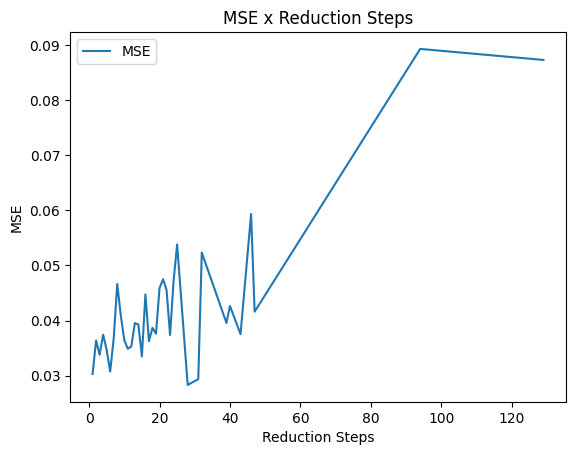

In [31]:
plt.plot(list(mse_dict.keys()), list(mse_dict.values()), label="MSE")

plt.xlabel("Reduction Steps")
plt.ylabel("MSE")
plt.title("MSE x Reduction Steps")
plt.legend()
plt.show()

In [32]:
def draw_pred_lines(y_pred, y_real):
    drawing_df = pd.DataFrame({"Pred": y_pred, "Real": y_real})
    drawing_df = drawing_df.sort_values("Real").reset_index(drop=True)

    for key_, val_ in drawing_df.items():
        plt.plot(range(len(val_)), val_, label=key_)

    plt.xlabel("No")
    plt.ylabel("Step Time")
    plt.title("Pred vs Real Step Time")
    plt.legend()
    plt.show()

1/1 [==============================] - 0s 22ms/step


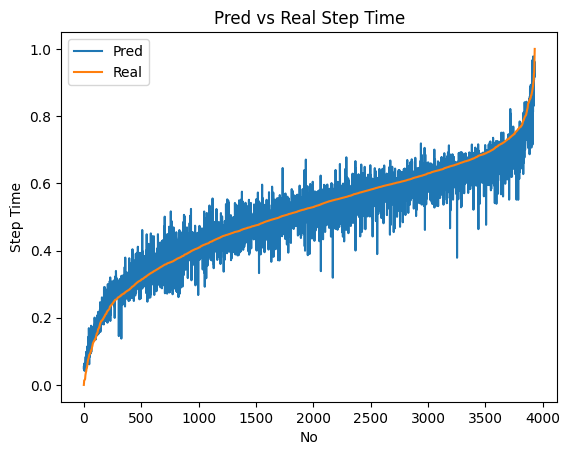

In [41]:
list_pred = []
list_real = []

for x_, y_ in list_data:
    for v_ in y_:
        list_real.append(v_)
    pred_value_ = model.predict(np.array([x_]))[0]
    for v_ in pred_value_:
        list_pred.append(v_[0])

draw_pred_lines(list_pred, list_real)

In [44]:
mean_squared_error(list_pred, list_real, squared=False)

0.04521153922665411

# Save the model

In [45]:
model_structure = model.to_json()
with open("./models/lstm_regression_return_sequence/structure.json", 'w') as json_file:
    json_file.write(model_structure)

model.save_weights("./models/lstm_regression_return_sequence/weights.h5")